# Analise de Dados do Mercado Financeiro com Python

Este notebook, visa explorar algumas possibilidades que o Python nos permite trabalhar com fundamentos básicos.

O Python possibilita de forma flexível tratar, estruturar e analisar dados de maneiras muito simples. Podendo assim, focar na lógica de como realizar a própria implementação. Além disso, o Python possibilita trabalhar com predição, o que ajuda muito na realização de backtests (método de análise utilizado no mercado financeiro que busca levar em consideração dados históricos importantes com o objetivo de tornar mais previsíveis os acontecimentos futuros) para o Mercado Financeiro.


## Entendendo os Candles



*   Vela Verde = Vela de Compra
        Quanto mais compra, maior a valorização do ativo.
*   Vela Vermelha = Vela de Venda
        Quanto mais venda, maior a desvalorização do ativo.


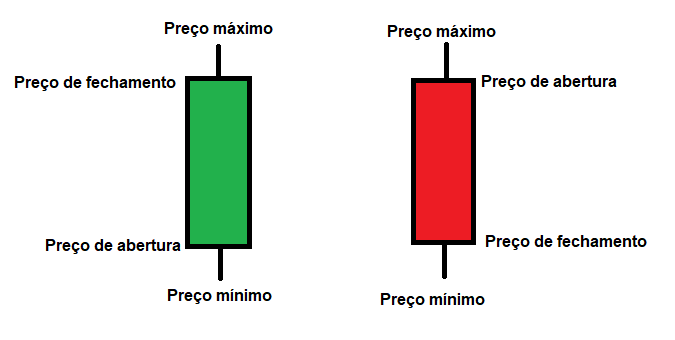

- Exemplo de Candle no mercado financeiro.
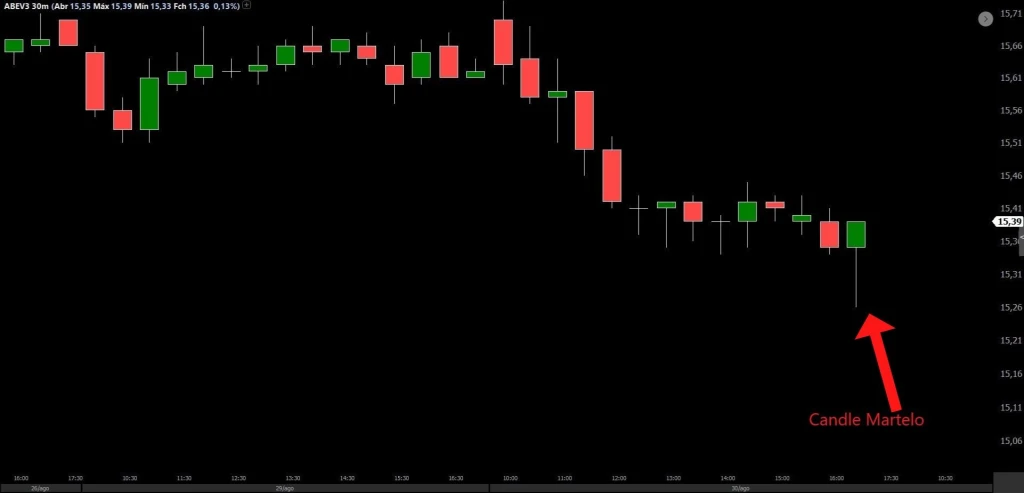

## Baixando Pacotes Externos


*   Yfinance: Pacote para importar os dados de um determinado ativo financeiro;
*   Plotly: Para realizar as plotagens dos gráficos dinâmico, referente aos ativos.



In [ ]:
!pip install yfinance
!pip install plotly

## Importando os pacotes para análise

Importando os pacotes para realizar os processamentos dos dados e também para análise gráfica do ativo.

In [ ]:
#Packages para trabalhar com datas e períodos/intervalos de data.
from datetime import date
from datetime import datetime, timedelta

# Raw Package para análise de dados
import pandas as pd

# Data Source
import yfinance as yf

# Data viz para auxiliar na geração de gráficos
import matplotlib.pyplot as plt
import plotly.graph_objs as go

## Análise de Dados

**O que será feito?**

*   Importação do Dataset;
*   Plotagem;
*   Criação de Indicador de Média Móvel;
*   Backtest.





### Importando Dataset

In [ ]:
# Importando dados Forex do mercado de ativos. Ativo AUDUSD dólar australiano/dólar amercicano
df_yf = yf.download(tickers = 'AUDUSD=X', period='2d', interval='5m') #Sempre deve ser de 1 a 2 d e sempre interval='5m' (5 minutos)

In [ ]:
# Visualizando do dataframe
df_yf

### Plotando Gráfico Candlestick

In [ ]:
# Gráfico (Candlestick) permite selecionar partes e visualizar trechos
fig = go.Figure(data=[go.Candlestick(
                    x=df_yf.index,
                    open=df_yf['Open'],
                    high=df_yf['High'],
                    low=df_yf['Low'],
                    close=df_yf['Close'],
                    name='High/Low')])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

### Criando Indicador de Média Móvel

In [ ]:
# Passando periodo de 21 periodos para criaçao da média movel na funcao rolling. Usando a coluna Close.
df_yf['MM21'] = df_yf['Close'].rolling(21).mean()

#Ultimos registros da tabela
df_yf.tail()

In [ ]:
# Registros iniciais da tabela não aparecem pois somente foram computados médias apos 21 periodos.
df_yf.head(23)

In [ ]:
# Plotando os dados da tabela
fig = go.Figure(data=[go.Candlestick(
                    x=df_yf.index,
                    open=df_yf['Open'],
                    high=df_yf['High'],
                    low=df_yf['Low'],
                    close=df_yf['Close'],
                    name='High/Low'),
                go.Scatter(x=df_yf.index, y=df_yf['MM21'], line=dict(color='orange', width=1), name='MM21')]) # passando dados da media movel, cores e expessura das linhas.

fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

### Backtest Com VectorBt

O Backtest é uma das formas de utilizar a ciência de dados para realizar previsão de ganhos e perdas em operações de trade, no mercado financeiro.

O Backtest, consiste em desenvolver uma estratégia e aplicar testes de forma automatizada em um determinado período de tempo passado. Com isso, avaliar se a estratégia desenvolvida irá retornar lucro ou perda de capital. Isso baseado em Big Data.

---

Iremos utilizar uma das mais recentes libs e também uma das mais promissoras para realizar esse trabalho e backtest. Esta é uma biblioteca que pode ser utilizada, tanto para backtest quanto para análise de dados. Porém, o ideal é unir os dois métodos para extrair o melhor da ferramenta.

In [ ]:
!pip install vectorbt

In [ ]:
import vectorbt as vbt

In [ ]:
# Com o vectorbt é possível importar os dados do mercado financeiro. star de uma semana atrás e acaba com 5 minutos atrás. Intevalo de 5 minutos.
dados = vbt.YFData.download('AUDUSD=X', missing_index='drop', start='1 week ago UTC', end='5 minutes ago UTC', interval='5m').get()

In [ ]:
# Visualizando o dataframe
dados

### Criando novos Indicadores de Médias Móveis

In [ ]:
# Selecionando a coluna de fechamento para gerar médias móveis.
prices = dados['Close']

# Gerando médias móveis. Criando séries nas variáveis.
media_rapida = vbt.MA.run(prices, 9) # média móvel para 9 períodos
media_lenta = vbt.MA.run(prices, 21) # média móvel para 21 períodos

### Implementação da Estratégia Com Médias Móveis

In [ ]:
# Cruzando as médias móveis. Variável indicando se compra ou vende o ativo quando a média cruza acima ou abaixo.
compra = media_rapida.ma_crossed_above(media_lenta)
venda = media_rapida.ma_crossed_below(media_lenta)

In [ ]:
# Passando os sinais
pf = vbt.Portfolio.from_signals(prices, compra, venda)

In [ ]:
# Plotando a estratégia, para visualizar compra e venda (Orders), Pnl(ganhos e perdas) e retorno.
pf.plot().show()

In [ ]:
# Dados estatísticos
pf.stats()

# BÔNUS: Estratégia com Indicador RSI

Nesse momento iremos fazer uma análise de compra e venda utilizando o indicador RSI. Esse indicador, nos ajuda a ter uma percepção da sobrecarga de compra e de venda. Quando o ativo está com uma grande carga de compra, significa que possivelmente ele irá ser revertido para a venda e vice-versa.

Índice de Força Relativa (RSI): Compara a magnitude dos ganhos e perdas recentes durante um período de tempo especificado para medir a velocidade e a mudança dos movimentos de preços de um título. É usado principalmente para tentar identificar condições de sobrecompra ou sobrevenda na negociação de um ativo.

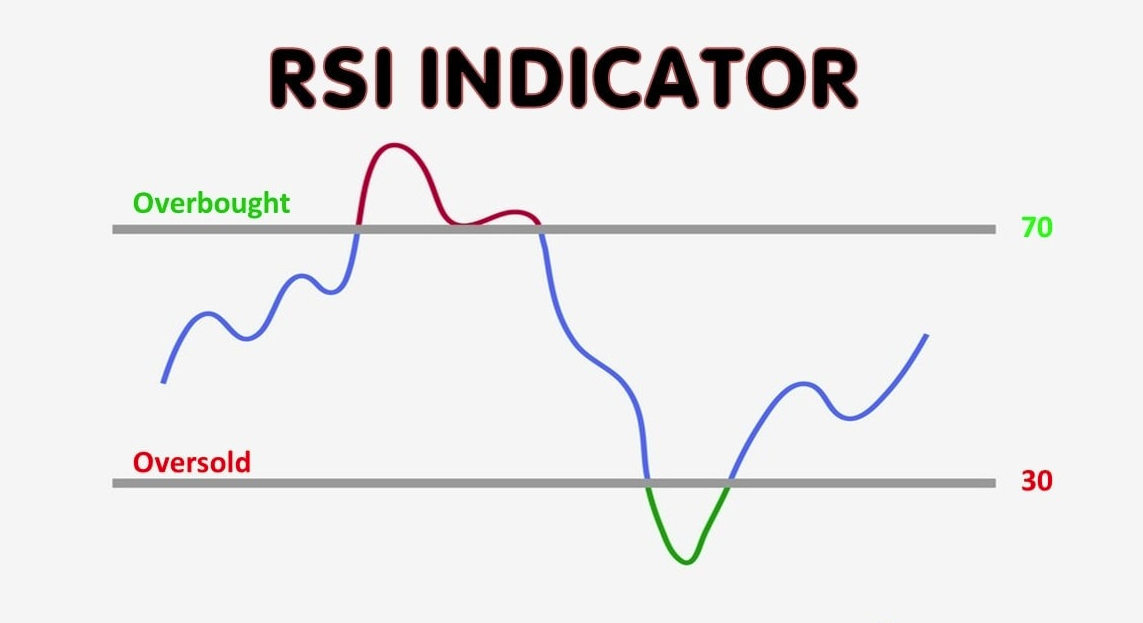

In [ ]:
# Passando os preços para o RSI
rsi = vbt.RSI.run(prices)

In [ ]:
# Quando cruzar para baixo (compra)
entradas = rsi.rsi_crossed_below(30)

In [ ]:
# Quando cruxar para cima (venda)
saidas = rsi.rsi_crossed_above(70)

Agora será implementado uma função para a plotagem do indicador com os respectivos pontos de compra(Entry) e venda(Exit).
Neste momento, será plotado todos os sinais de entradas e saídas

In [ ]:
def plot_rsi(rsi, entradas, saidas):
  fig = rsi.plot()
  entradas.vbt.signals.plot_as_entry_markers(rsi.rsi, fig=fig)
  saidas.vbt.signals.plot_as_exit_markers(rsi.rsi, fig=fig)
  return fig

plot_rsi(rsi, entradas, saidas).show()

Agora, iremos implementar o tratamento de sinais para não apresentar compras e vendas duplicadas no gráfico. Isso fará com que não apareça dois sinais de compra consecutivos e nem dois sinais de venda consecutivos, melhorando a visualização para a análise.

Isso significa que será apresentado um ponto de entrada/saída e depois um ponto de saída/entrada.

In [ ]:
entradas_limpas, saidas_limpas = entradas.vbt.signals.clean(saidas)
plot_rsi(rsi, entradas_limpas, saidas_limpas).show()

In [ ]:
# Configurando o portfolio
pf_rsi = vbt.Portfolio.from_signals(
    close = prices,
    entries = entradas_limpas,
    exits = saidas_limpas,
    size = 1.0, # 100%
    size_type = 'percent'
)

In [ ]:
pf_rsi.stats()

In [ ]:
pf_rsi.plot().show()

In [ ]:
# Montando todos os dados do backtest realizado
pf_rsi.trades.records_readable

# Conclusão
O Python é uma ótima ferramenta para realizar análise de dados. Podemos fazer diversos tipos de gráficos e data apps para benefício próprio ou em comunidade. Podemos colaborar com diversas pessoas dentro de uma determinada área, neste caso, foi escolhido um cenário específico dentro do mercado financeiro.

Porém, o Python pode ser utilizado em diversas áreas para trabalhar com análise de dados, estrutura de dados, engenharia de dados, visualização de dados, EDA e muitos outros exemplos, extraindo insights para diversas áreas e negócios.

Um dos pontos que ajuda bastante na utilização do Python, é a exploração de dados que pode ser feita de forma simples em um Jupyter Notebook como esse que você está vendo. Podendo gerar uma documentação focada na análise de dados, requisitos e prototipagem, previamente dito de uma arquitetura de D&A.

**Reflexão:**
Um bom trabalho de Análise de Dados é composto por um **JOIN** entre Analista e Ferramenta.

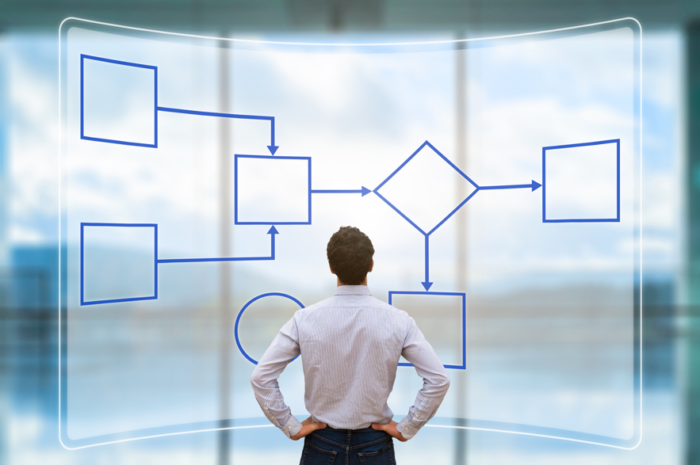